Dependecies and collecting images using openCV

In [128]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [129]:
import matplotlib.pyplot as plt
import json
import numpy as np


In [130]:
import os
import time
import uuid
import cv2


In [131]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 50

In [ ]:
import cv2
cap = cv2.VideoCapture(0)
# Check if the camera opened successfully
if not cap.isOpened():
    print("Error opening video stream or file")
    exit() 

for imgnum in range(number_images):
  print('Collecting image {}'.format(imgnum))
  ret, frame = cap.read()
  # Check if a frame was successfully read
  if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break
  imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname, frame)
  cv2.imshow('frame', frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

In [5]:
!labelme

Review dataset and build image loading function

In [132]:
gpu = tf.config.list_physical_devices('GPU')
len(gpu)

0

In [ ]:
# Load images into TF data pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True)
images.as_numpy_iterator().next()

In [134]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)
images.as_numpy_iterator().next()

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
# View images
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()


Partition Unaugmented Data

In [135]:
# move the matching labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)



SETUP ALBUMENTATIONS TRANSFORM PIPELINE

In [136]:
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params= alb.BboxParams(format='albumentations',
                                                     label_fields=['class_labels']))

In [137]:
img = cv2.imread(os.path.join('data','train','images','1a7b2367-6b92-11ef-9285-a511a15c1722.jpg'))
img.shape

(480, 640, 3)

In [138]:
#Load images
with open(os.path.join('data','train','labels','1a7b2367-6b92-11ef-9285-a511a15c1722.json'),'r') as f:
    label = json.load(f)

In [139]:
label['shapes'][0]['points']

[[228.02139037433156, 104.43850267379679],
 [390.0534759358288, 311.3903743315508]]

In [141]:
#Extract coordinates and rescale to match image resolution
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[228.02139037433156, 104.43850267379679, 390.0534759358288, 311.3903743315508]

In [142]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.3562834224598931,
 0.21758021390374332,
 0.6094585561497325,
 0.6487299465240641]

APPLY AUGMENTATIONS AND VIEW RESULTS

In [143]:
augmented = augmentor(image=img, bboxes=[coords],class_labels=['face'])
augmented['bboxes']

[(0.3911586452762924,
  0.3302436125965537,
  0.751229946524064,
  0.790136660724896)]

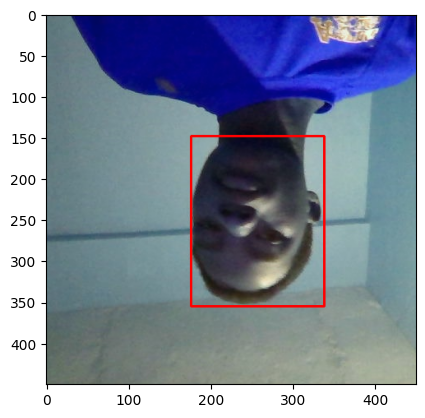

In [144]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image'])

BUILD AND RUN AUGMENTATION PIPELINE

In [145]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0

                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1

                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data',partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.32286096256684493, 0.9974376114081996, 0.051303475935828936, 0.7166889483065954, 'face'].


LOAD AUGMENTED IMAGES TO TENSORFLOW DATASET

In [146]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [147]:
train_images.as_numpy_iterator().next()

array([[[5.2696079e-01, 4.7598040e-01, 4.1323531e-01],
        [5.2549022e-01, 4.7450981e-01, 4.0931374e-01],
        [5.3069854e-01, 4.7971815e-01, 4.1697302e-01],
        ...,
        [4.7616422e-01, 1.5931373e-03, 9.0502448e-02],
        [4.9687499e-01, 4.2279414e-03, 8.6580880e-02],
        [5.0287992e-01, 2.4509805e-03, 7.2977938e-02]],

       [[5.3216910e-01, 4.7824755e-01, 4.2738971e-01],
        [5.4074752e-01, 4.8627451e-01, 4.3400735e-01],
        [5.3774512e-01, 4.8284313e-01, 4.3186274e-01],
        ...,
        [4.6672794e-01, 0.0000000e+00, 9.4178922e-02],
        [4.9307597e-01, 9.1911765e-04, 8.8541664e-02],
        [4.9803922e-01, 1.8382353e-04, 7.8431375e-02]],

       [[5.2126223e-01, 4.7420344e-01, 4.2714462e-01],
        [5.3131127e-01, 4.8327205e-01, 4.2886031e-01],
        [5.3774512e-01, 4.8284313e-01, 4.3186274e-01],
        ...,
        [4.7843137e-01, 0.0000000e+00, 9.7610295e-02],
        [5.0134802e-01, 7.3529412e-03, 1.0147059e-01],
        [5.0863969e-01

PREPARE LABELS

In [201]:
# BUILD LABEL LOADING FUNCTION
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    
    class_label = [label['class']]
    bbox_label = label['bbox']
    
    return class_label, bbox_label

def load_labels_wrapper(x):
    class_label, bbox_label = tf.py_function(load_labels, [x], [tf.uint8, tf.float32])
    
    # Explicitly setting the shapes to avoid unknown rank issues
    class_label.set_shape([1])  # Setting shape to a scalar (binary classification output)
    bbox_label.set_shape([4])   # Setting shape for the bounding box (x_min, y_min, x_max, y_max)
    
    return class_label, bbox_label


In [202]:
# LOAD LABELS TO  TENSORFLOW DATASET
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(load_labels_wrapper)

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(load_labels_wrapper)

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(load_labels_wrapper)




COMBINE LABEL AND IMAGE SAMPLES

In [203]:
#check partition lengths 
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4200, 4200, 840, 840, 900, 900)

In [204]:
# Create final dataset(images/labels)
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [205]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.        , 0.        , 0.        , 0.        ],
        [0.33878788, 0.2223173 , 0.6465716 , 0.66200835],
        [0.7064171 , 0.        , 1.        , 0.41653   ],
        [0.33276293, 0.28437313, 0.69521093, 0.75377303],
        [0.        , 0.        , 0.        , 0.        ],
        [0.30235294, 0.22520499, 0.611325  , 0.6387522 ],
        [0.4625906 , 0.5454902 , 0.8119667 , 1.        ],
        [0.41411763, 0.2075817 , 0.74329174, 0.6377659 ]], dtype=float32))

VIEW IMAGES AND ANNOTATIONS

In [206]:
data_samples = train.as_numpy_iterator()

In [207]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


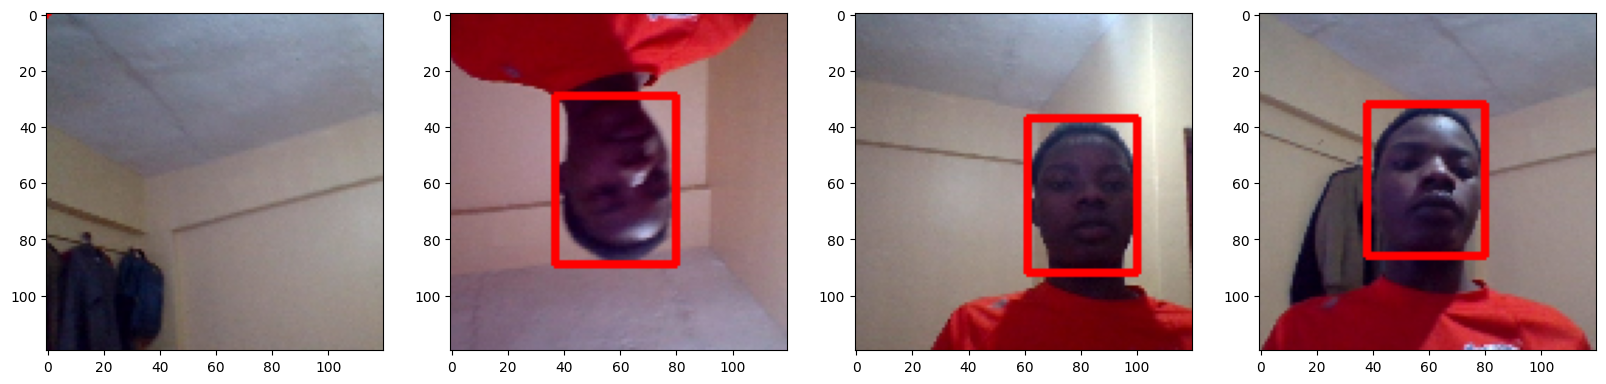

In [208]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = np.copy(res[0][idx])
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0),2
                  )
    ax[idx].imshow(sample_image)

BUILD A DEEP LEARNING USING FUNCTIONAL API

In [209]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [210]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D,Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [211]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

BUILD INSTANCE OF NETWORK

In [212]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    
    vgg =VGG16(include_top=False)(input_layer)

    # classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1,activation='sigmoid')(class1)

    # regression bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs = [class2, regress2])
    return facetracker


TEST AOUT NEURAL NETWORK

In [213]:
facetracker = build_model()
facetracker.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      2,049 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 4)         │      8,196 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [214]:
X,y = train.as_numpy_iterator().next()

In [215]:
X.shape

(8, 120, 120, 3)

In [216]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(array([[0.41858196],
        [0.5744456 ],
        [0.5075104 ],
        [0.49074784],
        [0.50784343],
        [0.5475403 ],
        [0.43540052],
        [0.49330023]], dtype=float32),
 array([[0.4371323 , 0.66583425, 0.5877042 , 0.3999618 ],
        [0.40243772, 0.6536677 , 0.51455605, 0.48662773],
        [0.3620964 , 0.61007863, 0.53297967, 0.49220854],
        [0.44851166, 0.6803456 , 0.59854704, 0.45836782],
        [0.37340394, 0.6300126 , 0.536965  , 0.4437367 ],
        [0.46934894, 0.60175514, 0.56911683, 0.47474417],
        [0.41780335, 0.6281975 , 0.551785  , 0.40221062],
        [0.34212297, 0.6125651 , 0.5334053 , 0.46981034]], dtype=float32))

DIFINE LOSSES AND OPTIMIZERS

In [217]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [218]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [219]:
# create localization loss and classification loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [220]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [221]:
# test out loss metrics
localization_loss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0576353>

In [222]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.70849276>

In [223]:
print(y[0].shape)  # Should be (batch_size, 1)
print(y[1].shape)  # Should be (batch_size, 4)


(8, 1)
(8, 4)


In [224]:
print(y[1].shape)
print(classes.shape)


(8, 4)
(8, 1)


In [225]:
print("y[0] shape (classification labels):", tf.shape(y[0]))
print("y[1] shape (bounding box labels):", tf.shape(y[1]))
print("classes shape (predicted classes):", tf.shape(classes))
print("coords shape (predicted bounding boxes):", tf.shape(coords))


y[0] shape (classification labels): tf.Tensor([8 1], shape=(2,), dtype=int32)
y[1] shape (bounding box labels): tf.Tensor([8 4], shape=(2,), dtype=int32)
classes shape (predicted classes): tf.Tensor([8 1], shape=(2,), dtype=int32)
coords shape (predicted bounding boxes): tf.Tensor([8 4], shape=(2,), dtype=int32)


TRAIN NEURAL NETWORK

In [226]:
# Create custom model
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        
        with tf.GradientTape() as tape: 
            # Forward pass
            classes, coords = self.model(X, training=True)
            
            # Debugging: Print shapes to ensure they match
            print(f"y[0] shape: {y[0].shape}, classes shape: {classes.shape}")
            print(f"y[1] shape: {y[1].shape}, coords shape: {coords.shape}")
            
            # Ensure y[0] and classes are of the same shape and type
            y_true_class = tf.reshape(tf.cast(y[0], tf.float32), [-1])
            y_pred_class = tf.reshape(tf.cast(classes, tf.float32), [-1])
            
            # Ensure y[1] and coords are of the same shape and type
            y_true_coords = tf.cast(y[1], tf.float32)
            
            # Compute the classification and regression losses
            batch_classloss = self.closs(y_true_class, y_pred_class)
            batch_localizationloss = self.lloss(y_true_coords, coords)
            
            # Compute total loss
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            # Compute gradients and apply them
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [227]:
model = FaceTracker(facetracker)

model.compile(opt, classloss, regressloss)

TRAIN

In [228]:
logdir = 'logs'

In [229]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [230]:
for batch in train.take(1):
    X, y = batch
    class_labels, bbox_labels = y
    classes, coords = model(X)

    print("class_labels shape:", class_labels.shape)
    print("bbox_labels shape:", bbox_labels.shape)
    print("classes (predicted) shape:", classes.shape)
    print("coords (predicted) shape:", coords.shape)


class_labels shape: (8, 1)
bbox_labels shape: (8, 4)
classes (predicted) shape: (8, 1)
coords (predicted) shape: (8, 4)


In [231]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/5


y[0] shape: (None, 1), classes shape: (None, 1)
y[1] shape: (None, 4), coords shape: (None, 4)
y[0] shape: (None, 1), classes shape: (None, 1)
y[1] shape: (None, 4), coords shape: (None, 4)
525/525 ━━━━━━━━━━━━━━━━━━━━ 1052s 2s/step - class_loss: 0.0889 - regress_loss: 0.2587 - total_loss: 0.3031 - val_class_loss: 4.9490 - val_regress_loss: 0.9632 - val_total_loss: 3.4377
Epoch 2/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 1133s 2s/step - class_loss: 0.0295 - regress_loss: 0.0761 - total_loss: 0.0908 - val_class_loss: 5.6494 - val_regress_loss: 1.3148 - val_total_loss: 4.1395
Epoch 3/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 1172s 2s/step - class_loss: 0.0351 - regress_loss: 0.0894 - total_loss: 0.1069 - val_class_loss: 3.3184 - val_regress_loss: 0.6661 - val_total_loss: 2.3253
Epoch 4/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 1193s 2s/step - class_loss: 0.0218 - regress_loss: 0.0488 - total_loss: 0.0597 - val_class_loss: 2.7103 - val_regress_loss: 0.6124 - val_total_loss: 1.9675
Epoch 5/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 1

PLOT PERFORMANCE